In [1]:
# Import relevant modules needed for simple segmentation
#
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import copy
import time

In [2]:
#================================================================;
#  Function-1: Write VTK file to visualize part of the XCT data  ;
#================================================================;
def write_VTK_file(vtk_fl_name, num_nodes, num_elements, nodes_per_element, \
                    coord_matrix, connectivity_matrix, mat_id_matrix):

    #------------------------------------------------;
    #  Write coord, connectivity, and scalar fields  ;
    #------------------------------------------------;
    fid = open(vtk_fl_name + '.vtk','w+')
    #
    fid.write('# vtk DataFile Version 2.0 \n') #Write the 'Header' for ASCII files; HEADER: Lines required in output file = '5' 
    fid.write('Written using Python (TEST CASE) \n')
    fid.write('ASCII \n')
    fid.write('DATASET UNSTRUCTURED_GRID \n \n')
    #
    fid.write('POINTS ' + str(int(num_nodes)) + ' float \n') #Write the coordinate matrix -- Relative
    for i in range(0, num_nodes):
        fid.write(str(float(coord_matrix[i,0])) + ' ' + \
                    str(float(coord_matrix[i,1])) + ' ' + \
                    str(float(coord_matrix[i,2])) + '\n')
    fid.write('\n')
    #
    fid.write('CELLS ' + str(int(num_elements)) + ' ' + \
              str(int(num_elements*(nodes_per_element+1))) + ' \n') #Write the connectivity matrix
    for i in range(0, num_elements):
        fid.write(str(8) + ' ' + str(int(connectivity_matrix[i,0])) + \
                  ' ' + str(int(connectivity_matrix[i,1])) + \
                  ' ' + str(int(connectivity_matrix[i,2])) + \
                  ' ' + str(int(connectivity_matrix[i,3])) + \
                  ' ' + str(int(connectivity_matrix[i,4])) + \
                  ' ' + str(int(connectivity_matrix[i,5])) + \
                  ' ' + str(int(connectivity_matrix[i,6])) + \
                  ' ' + str(int(connectivity_matrix[i,7])) + '\n')
    fid.write('\n')
    #
    fid.write('CELL_TYPES ' + str(int(num_elements)) +  ' \n') #Write cell types VTK_HEXAHEDRON (=12)
    for i in range(0, num_elements):
        fid.write(str(12) + '\n')
    fid.write('\n')
    ## (https://stackoverflow.com/questions/30596972/with-vtk-python-api-add-multiple-scalars-to-unstructured-grid-cells)
    #
    fid.write('CELL_DATA ' + str(int(num_elements)) + ' \n') #Write permeability
    fid.write('SCALARS Material-ID FLOAT \n') #Write material ID
    fid.write('LOOKUP_TABLE default \n')
    for i in range(0, num_elements):
        fid.write(str(float(mat_id_matrix[i])) + '\n')
    fid.write('\n')
    #
    fid.close()

In [3]:
#*****************************;
#  1. Paths and loading data  ;
#*****************************;
path       = '/Users/mudu605/Downloads/XCT/'
path_data  = path + 'Images/'
path_plots = path + 'Img_Binarize_v2/'

In [4]:
#******************************************************************;
#  2. Mesh and connectivity specifics for visualizing in ParaView  ;
#******************************************************************;
Lx          = 30.35/1000 #30.35mm
Ly          = 30.35/1000 #30.35mm
Lz          = 30.35/1000 #30.35mm
#
XSeed       = 500+1 #501 nodes in X-dir
YSeed       = 500+1 #501 nodes in Y-dir
ZSeed       = 500+1 #501 nodes in Z-dir
#
xcoord_list = np.linspace(0,Lx,XSeed) #(501,)
ycoord_list = np.linspace(0,Ly,YSeed) #(501,)
zcoord_list = np.linspace(0,Lz,ZSeed) #(501,)
#
#Right-handed coordinate system
#Create coordinate matrix -- Structured grid
#https://bytebucket.org/pflotran/pflotran/wiki/Depreciated/Documentation/Files/user_manual.pdf?rev=f8f2c75ed07230a305fae0520ca63a9e6badd433
#Look into pg-90
num_nodes         = XSeed*YSeed*ZSeed #501*501*501 --> 125751501
coord_list        = np.ndarray(shape = (num_nodes,3), dtype = float) #(125751501,3) = (125751501,3)
#
for k in range(0,ZSeed): #Z-dir
    for j in range(0,YSeed): #Y-dir
        for i in range(0,XSeed): #X-dir
            xcoord             = xcoord_list[i]
            ycoord             = ycoord_list[j]
            zcoord             = zcoord_list[k]
            #
            node               = i + j * XSeed + k * XSeed * YSeed #0-based coord
            coord_list[node,0] = xcoord
            coord_list[node,1] = ycoord
            coord_list[node,2] = zcoord
            #print(node, i, j, k, xcoord, ycoord, zcoord)

#Right-handed coordinate system
#Create connectivity matrix -- Structured grid
num_elements      = (XSeed - 1) * (YSeed - 1) * (ZSeed - 1) #500*500*500 = 125000000
connectivity_list = np.ndarray(shape = (num_elements,8), dtype = int) #(125000000,8)
#
counter = 0
for k in range(0,ZSeed-1): #Create connectivity matrix
    for j in range(0,YSeed-1):
        for i in range(0,XSeed-1):
            index                        = i + j * XSeed + k * XSeed * YSeed #Node number
            elem_index                   = i + j * (XSeed - 1) + k * (XSeed - 1) * (YSeed - 1) #Cell number
            #
            connectivity_list[counter,0] = index
            connectivity_list[counter,1] = index + 1
            connectivity_list[counter,2] = index + 1 + XSeed
            connectivity_list[counter,3] = index + XSeed
            connectivity_list[counter,4] = index + XSeed * YSeed
            connectivity_list[counter,5] = index + 1 + XSeed * YSeed
            connectivity_list[counter,6] = index + 1 + XSeed + XSeed * YSeed
            connectivity_list[counter,7] = index + XSeed + XSeed * YSeed
            #
            #print(counter,elem_index,i,j,k,index)
            counter                      = counter + 1

In [5]:
#********************************************************************;
#  3. Get 2D images and stack it as 3D with ML-enabled thresholding  ;
#********************************************************************;
img_3d_stack = np.zeros((YSeed-1,ZSeed-1,XSeed-1), dtype = int) #(500,500,500) ordering for np array
th3_3d_stack = np.zeros((YSeed-1,ZSeed-1,XSeed-1), dtype = int) #(500,500,500) ordering for np array
#
for stride in range(0,YSeed-1):
    if stride < 10:
        img = cv.imread(path_data + 'Bean Bucket 8bit image000' + str(stride) + '.tif', cv.IMREAD_GRAYSCALE)
    if stride >= 10 and stride < 100:
        img = cv.imread(path_data + 'Bean Bucket 8bit image00' + str(stride) + '.tif', cv.IMREAD_GRAYSCALE)
    if stride >= 100:
        img = cv.imread(path_data + 'Bean Bucket 8bit image0' + str(stride) + '.tif', cv.IMREAD_GRAYSCALE)
    #print(stride)
    #print(img)
    #
    # global thresholding
    #ret1,th1 = cv.threshold(img,127,255,cv.THRESH_BINARY)
    #
    # Otsu's thresholding
    #ret2,th2 = cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    #
    # Otsu's thresholding after Gaussian filtering
    blur = cv.GaussianBlur(img,(5,5),0)
    ret3,th3 = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    #
    img_3d_stack[stride,:,:] = copy.deepcopy(np.flipud(img))
    th3_3d_stack[stride,:,:] = copy.deepcopy(np.flipud(th3))
    #
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(th3, 'gray')
    plt.savefig(path_plots+ 'th3_' + str(stride) + '.png')
    fig.tight_layout()
    plt.close(fig)

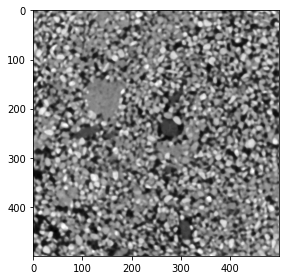

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(img_3d_stack[50,:,:], 'gray')
fig.tight_layout()
plt.show()

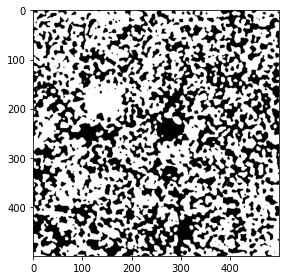

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(th3_3d_stack[50,:,:], 'gray')
fig.tight_layout()
plt.show()

In [9]:
#*******************************************************************;
#  4. Image binarization as VTK file and visualization in ParaView  ;
#*******************************************************************;
mat_id_list   = np.ndarray(shape = (num_elements,1), dtype = int) #(125000000,1) #materials ids for h5 and VTK
th3_id_list   = np.ndarray(shape = (num_elements,1), dtype = int) #(125000000,1) #materials ids for h5 and VTK
#
counter = 0
for k in range(0,ZSeed-1):
    for j in range(0,YSeed-1): #Y-dir
        for i in range(0,XSeed-1): #X-dir
            elem_index                = i + j * (XSeed - 1) + k * (XSeed - 1) * (YSeed - 1) #Cell number
            mat_id_list[elem_index,0] = img_3d_stack[j,k,i]
            th3_id_list[elem_index,0] = th3_3d_stack[j,k,i]

nodes_per_element = 8
vtk_fl_name       = path_plots + 'Th3_3D_file_v2'
#
write_VTK_file(vtk_fl_name, num_nodes, num_elements, nodes_per_element, \
                coord_list, connectivity_list, th3_id_list)